In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests


In [177]:
#Create list of players+decks from Limitless

# The URL you want to scrape
url = "https://limitlesstcg.com/tournaments/375"

# Fetch the HTML content
response = requests.get(url)
if response.status_code != 200:
    print("Failed to get the webpage")
    exit()

# Initialize BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Lists to hold the player names and decks
player_names = []
decks = []

# Loop through each player row in the HTML
for row in soup.select('tr'):
    player = row.select_one('a[href^="/players"]')
    deck = row.select_one('span[data-tooltip]')
    
    if player and deck:
        player_names.append(player.text)
        
        deck_tooltip = deck['data-tooltip']
        decks.append(deck_tooltip)

# Create a DataFrame
player_decks = pd.DataFrame({
    'Player Name': player_names,
    'Deck': decks
})

# Print the DataFrame or save it to a CSV file
player_decks['Player Name'] = player_decks['Player Name'].str.strip().str.lower()
rename_dict = {'tom mizutani':'tomu mizutani',
            'hiromi isono': '広明 磯野',
            'aaron friedman' : 'aaron freetos friedman',
       'tadashi miyamoto' : 'da ashi',
            'juan andree mejía' : 'juan andree',
            'agustin campo' : 'agustín campo',
       'tomoyuki abino' : '阿比野 友之', 
            'isaac chen im sheng' : 'im sheng chen', 
            'shunsuke sowa' : '俊介 曽羽',
       'akari yamanoto' : 'akari yamamoto'}
player_decks['Player Name'].replace(rename_dict, inplace=True)
#df.to_csv('player_decks.csv', index=False)

In [179]:
matches = pd.read_csv("worlds_day2.csv", header=None)
matches[['Player1', 'Country1', 'Player2', 'Country2', 'Result']] = matches[0].str.extract(r'([\w\s-]+)\s\[(\w+)\]\t([\w\s-]+)\s\[(\w+)\]\t([WLT])')
matches.drop(0, axis=1, inplace=True)
players = matches[['Player1', 'Player2', 'Result']]
players['Player1'] = players['Player1'].str.strip().str.lower()
players['Player2'] = players['Player2'].str.strip().str.lower()
players=players.dropna()



<ipython-input-179-31991e3df44d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Player1'] = players['Player1'].str.strip().str.lower()
<ipython-input-179-31991e3df44d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Player2'] = players['Player2'].str.strip().str.lower()


In [182]:
#Test for names that don't match between decks and standings/matches
testing = players.merge(player_decks, left_on='Player1', right_on='Player Name', how='left')
testing_na = testing[testing.isna().any(axis=1)]
testing_na['Player1'].unique()

testing2 = players.merge(player_decks, left_on='Player1', right_on='Player Name', how='right')
testing_na2 = testing2[testing2.isna().any(axis=1)]
testing_na2['Player Name'].unique()
#deal with cases: capitalization, a few slightly different names, japanese characters

array([], dtype=object)

In [198]:
deck_matchups = players.merge(player_decks, left_on='Player1', right_on='Player Name', how='left')
deck_matchups.rename(columns={'Deck': 'Deck1'}, inplace=True)
deck_matchups.drop('Player Name', axis=1, inplace=True)

deck_matchups = deck_matchups.merge(player_decks, left_on='Player2', right_on='Player Name', how='left')
deck_matchups.rename(columns={'Deck': 'Deck2'}, inplace=True)
deck_matchups.drop('Player Name', axis=1, inplace=True)

deck_matchups.drop(['Player1', 'Player2'], axis=1, inplace=True)
deck_matchups = deck_matchups.dropna()


# Initialize an empty dictionary to hold matchups
matchup_dict = {}

# Iterate through each row to populate the matchup dictionary
for _, row in deck_matchups.iterrows():
    deck1, deck2, result = row['Deck1'], row['Deck2'], row['Result']
    if deck1 not in matchup_dict:
        matchup_dict[deck1] = {}
    if deck2 not in matchup_dict[deck1]:
        matchup_dict[deck1][deck2] = {'W': 0, 'L': 0, 'T': 0}

    # Update based on result
    if result == 'W':
        matchup_dict[deck1][deck2]['W'] += 1
    elif result == 'L':
        matchup_dict[deck1][deck2]['L'] += 1
    elif result == 'T':
        matchup_dict[deck1][deck2]['T'] += 1

# Convert to DataFrame
final_data = {}
for deck1, opponents in matchup_dict.items():
    for deck2, records in opponents.items():
        final_data[(deck1, deck2)] = f"{records['W']}-{records['L']}-{records['T']}"

# Create an empty DataFrame with unique decks as index and columns
unique_decks = list(set(deck_matchups['Deck1'].unique().tolist() + deck_matchups['Deck2'].unique().tolist()))
matchup_df = pd.DataFrame(index=unique_decks, columns=unique_decks)

# Populate the DataFrame
for (deck1, deck2), record in final_data.items():
    matchup_df.at[deck1, deck2] = record

matchup_df


,Arceus Duraludon Umbreon,Arceus,Zoroark Box,Gardevoir,Mew Genesect,Inteleon Urshifu,Arceus Duraludon,Palkia,Arceus Umbreon,Fusion Mew,...,Lost Box Charizard,Miraidon Regieleki,Goodra LZ Box,Miraidon Flaaffy,Arceus Giratina,Giratina LZ Box,Counter Box,Arceus Goodra,Inteleon,Palkia Gardevoir
Arceus Duraludon Umbreon,NaN,NaN,NaN,0-2-0,0-1-0,NaN,NaN,NaN,0-1-0,1-1-0,...,NaN,NaN,NaN,NaN,0-1-0,1-2-0,NaN,0-1-0,NaN,NaN
Arceus,NaN,NaN,NaN,1-0-0,NaN,1-1-0,NaN,NaN,NaN,1-0-0,...,NaN,NaN,NaN,NaN,NaN,0-0-1,NaN,NaN,NaN,NaN
Zoroark Box,NaN,NaN,NaN,0-0-1,NaN,NaN,NaN,NaN,NaN,0-1-0,...,0-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gardevoir,2-0-0,0-1-0,0-0-1,10-10-4,1-1-1,2-2-0,1-0-0,1-0-0,2-1-1,4-6-4,...,1-0-0,NaN,1-0-0,2-1-0,3-1-0,7-9-5,NaN,1-0-0,2-1-0,1-1-0
Mew Genesect,1-0-0,NaN,NaN,1-1-1,NaN,0-1-0,NaN,0-1-0,NaN,0-1-0,...,NaN,NaN,NaN,0-1-0,0-1-0,1-0-0,NaN,NaN,NaN,NaN
Inteleon Urshifu,NaN,1-1-0,NaN,2-2-0,1-0-0,0-0-2,NaN,1-0-0,NaN,0-2-0,...,1-0-0,NaN,NaN,0-1-0,2-1-0,2-4-0,1-0-0,NaN,NaN,NaN
Arceus Duraludon,NaN,NaN,NaN,0-1-0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0-1-0,0-1-0,NaN,0-1-0,NaN,NaN,NaN
Palkia,NaN,NaN,NaN,0-1-0,1-0-0,0-1-0,NaN,NaN,NaN,1-1-0,...,NaN,1-0-0,NaN,1-0-0,1-0-0,1-1-0,NaN,NaN,NaN,NaN
Arceus Umbreon,1-0-0,NaN,NaN,1-2-1,NaN,NaN,NaN,NaN,NaN,5-3-0,...,NaN,0-1-0,NaN,NaN,NaN,2-3-0,NaN,NaN,NaN,NaN
Fusion Mew,1-1-0,0-1-0,1-0-0,6-4-4,1-0-0,2-0-0,NaN,1-1-0,3-5-0,16-16-2,...,NaN,1-0-0,1-2-2,3-1-1,12-2-0,9-7-1,NaN,NaN,NaN,0-1-0


In [191]:
def calc_percentage(wlt_str):
    if pd.isna(wlt_str):
        return None
    w, l, t = map(int, wlt_str.split('-'))
    if w + l == 0:
        return None
    return round((w / (w + l)) * 100,1)



In [195]:
percentage_df = matchup_df.applymap(calc_percentage)
percentage_df

,Arceus Duraludon Umbreon,Arceus,Zoroark Box,Gardevoir,Mew Genesect,Inteleon Urshifu,Arceus Duraludon,Palkia,Arceus Umbreon,Fusion Mew,...,Lost Box Charizard,Miraidon Regieleki,Goodra LZ Box,Miraidon Flaaffy,Arceus Giratina,Giratina LZ Box,Counter Box,Arceus Goodra,Inteleon,Palkia Gardevoir
Arceus Duraludon Umbreon,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,50.0,...,NaN,NaN,NaN,NaN,0.0,33.3,NaN,0.0,NaN,NaN
Arceus,NaN,NaN,NaN,100.0,NaN,50.0,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoroark Box,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gardevoir,100.0,0.0,NaN,50.0,50.0,50.0,100.0,100.0,66.7,40.0,...,100.0,NaN,100.0,66.7,75.0,43.8,NaN,100.0,66.7,50.0
Mew Genesect,100.0,NaN,NaN,50.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,100.0,NaN,NaN,NaN,NaN
Inteleon Urshifu,NaN,50.0,NaN,50.0,100.0,NaN,NaN,100.0,NaN,0.0,...,100.0,NaN,NaN,0.0,66.7,33.3,100.0,NaN,NaN,NaN
Arceus Duraludon,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN
Palkia,NaN,NaN,NaN,0.0,100.0,0.0,NaN,NaN,NaN,50.0,...,NaN,100.0,NaN,100.0,100.0,50.0,NaN,NaN,NaN,NaN
Arceus Umbreon,100.0,NaN,NaN,33.3,NaN,NaN,NaN,NaN,NaN,62.5,...,NaN,0.0,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN
Fusion Mew,50.0,0.0,100.0,60.0,100.0,100.0,NaN,50.0,37.5,50.0,...,NaN,100.0,33.3,75.0,85.7,56.2,NaN,NaN,NaN,0.0


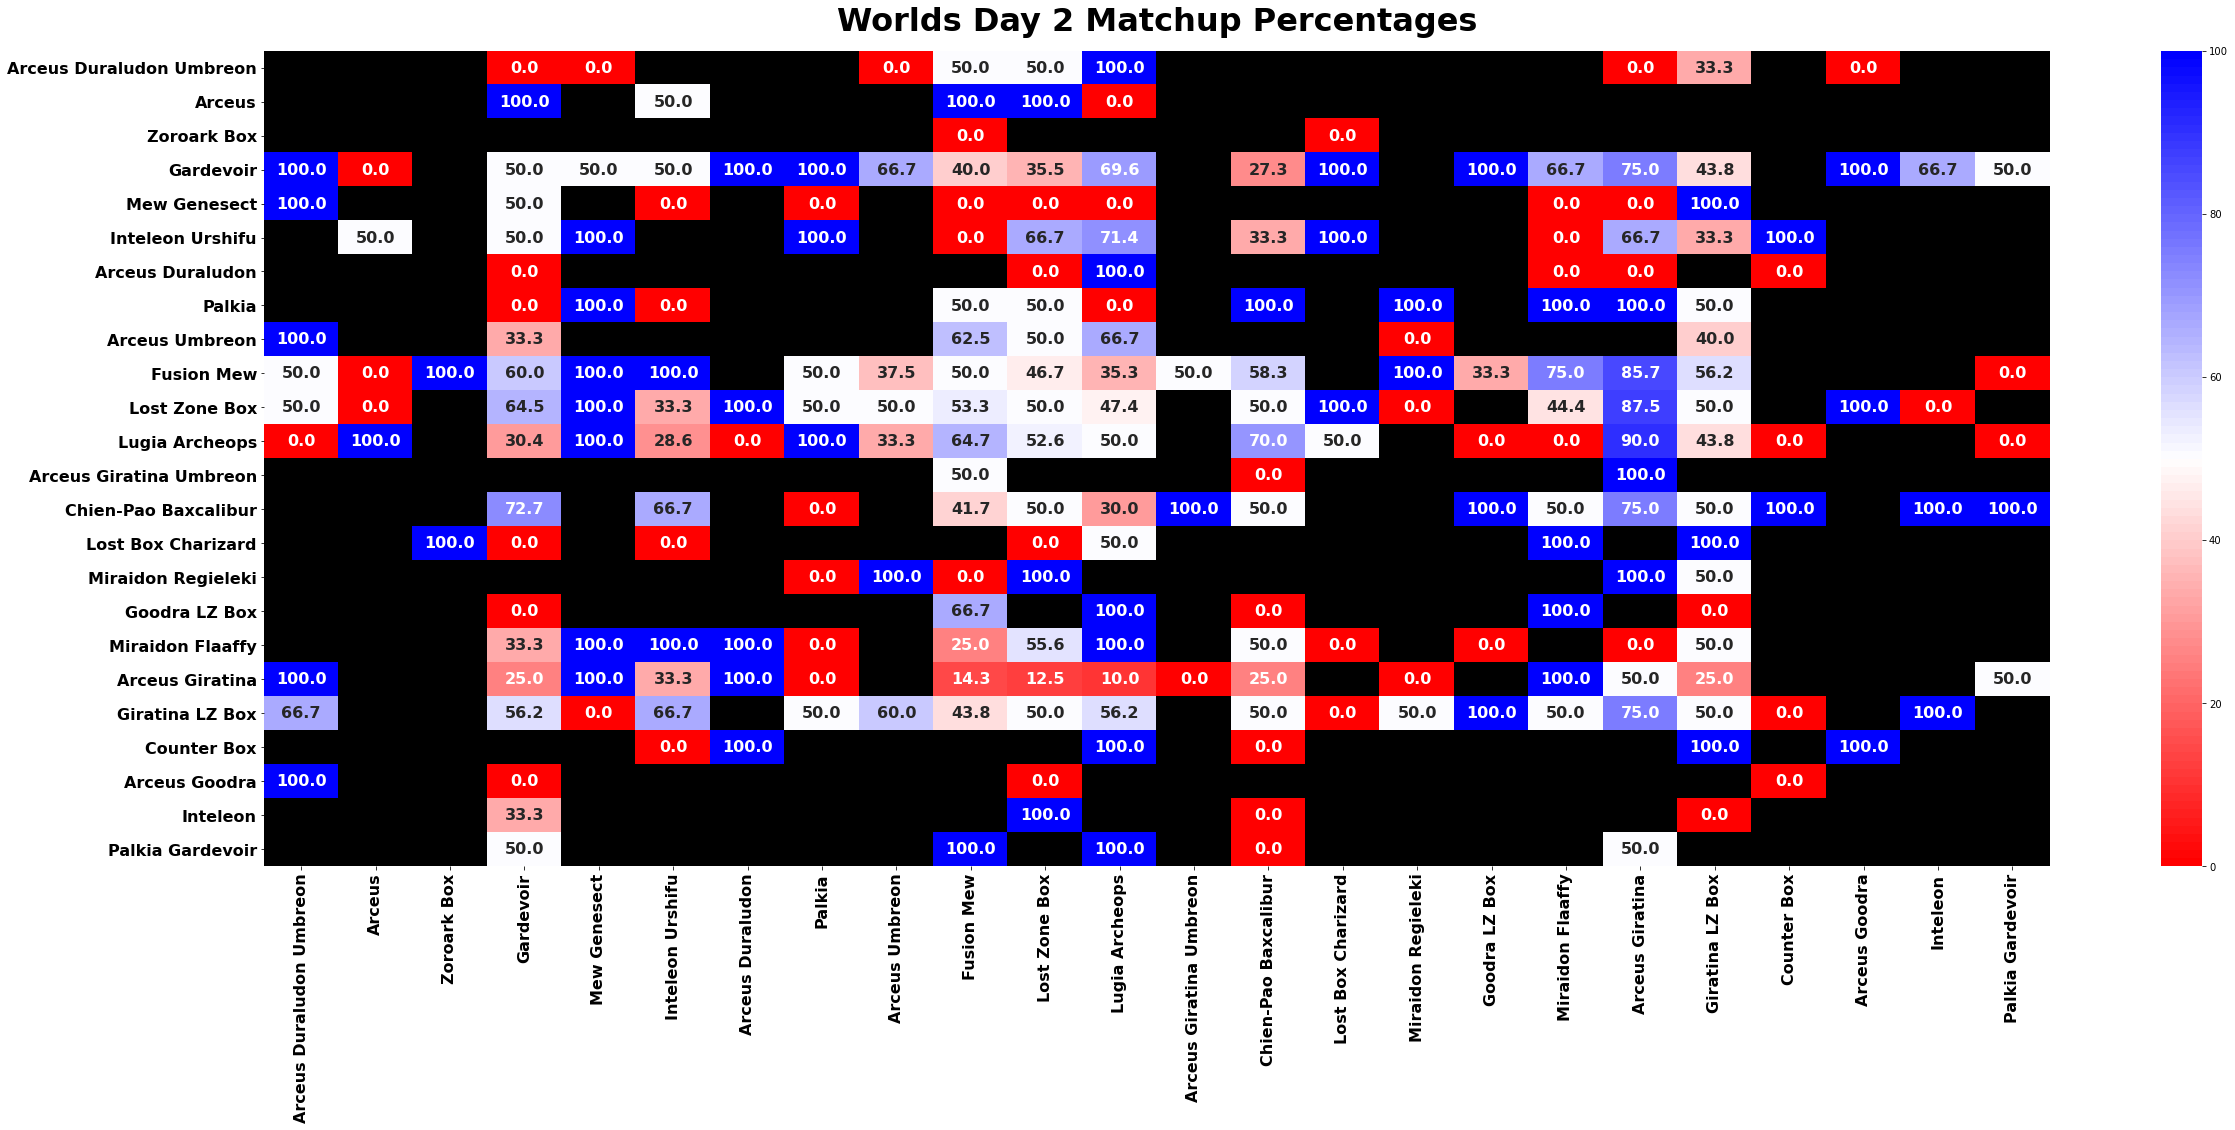

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100  # Number of bins
cmap_name = 'custom1'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='black')

plt.figure(figsize=(40, 15))
ax = sns.heatmap(percentage_df, annot=True, cmap=custom_cmap, fmt=".1f", 
            annot_kws={"weight": "bold", "size": 16})


plt.xticks(fontweight='bold', fontsize= 16)
plt.yticks(fontweight='bold', fontsize= 16)

plt.title('Worlds Day 2 Matchup Percentages', fontweight='bold', fontsize= 32, pad=20)


plt.show()


Consolidate Decks

In [184]:
#if we want to consolidate some names
player_decks_consolidated = player_decks.copy()
player_decks_consolidated['Deck'] = player_decks_consolidated['Deck'].replace({'Miraidon Flaaffy' : 'Miraidon', 
                                                                               'Miraidon Regieleki' : 'Miraidon',
                                           'Arceus Umbreon' : 'Arceus no Tina', 
                                            'Arceus Duraludon Umbreon' : 'Arceus no Tina',
                                           'Arceus' : 'Arceus no Tina', 'Arceus Goodra' : 'Arceus no Tina',
                                           'Arceus Duraludon' : 'Arceus no Tina', 
                                           'Arceus Giratina Umbreon' : 'Arceus Giratina',
                                           'Fusion Mew' : 'Mew', 'Mew Genesect' : 'Mew'})


In [186]:
# Get the value counts
value_counts = player_decks_consolidated['Deck'].value_counts()

# Select the values where the count > 2
to_keep = value_counts[value_counts > 2].index

# Filter the DataFrame to keep these values only
player_decks_consolidated = player_decks_consolidated[player_decks_consolidated['Deck'].isin(to_keep)]


player_decks_consolidated['Deck'].value_counts()

Lost Zone Box           30
Mew                     23
Gardevoir               23
Lugia Archeops          22
Giratina LZ Box         19
Arceus Giratina         12
Chien-Pao Baxcalibur    11
Arceus no Tina           9
Inteleon Urshifu         6
Miraidon                 5
Name: Deck, dtype: int64

In [187]:
deck_matchups = players.merge(player_decks_consolidated, left_on='Player1', right_on='Player Name', how='left')
deck_matchups.rename(columns={'Deck': 'Deck1'}, inplace=True)
deck_matchups.drop('Player Name', axis=1, inplace=True)

deck_matchups = deck_matchups.merge(player_decks_consolidated, left_on='Player2', right_on='Player Name', how='left')
deck_matchups.rename(columns={'Deck': 'Deck2'}, inplace=True)
deck_matchups.drop('Player Name', axis=1, inplace=True)

deck_matchups.drop(['Player1', 'Player2'], axis=1, inplace=True)
deck_matchups = deck_matchups.dropna()


# Initialize an empty dictionary to hold matchups
matchup_dict = {}

# Iterate through each row to populate the matchup dictionary
for _, row in deck_matchups.iterrows():
    deck1, deck2, result = row['Deck1'], row['Deck2'], row['Result']
    if deck1 not in matchup_dict:
        matchup_dict[deck1] = {}
    if deck2 not in matchup_dict[deck1]:
        matchup_dict[deck1][deck2] = {'W': 0, 'L': 0, 'T': 0}

    # Update based on result
    if result == 'W':
        matchup_dict[deck1][deck2]['W'] += 1
    elif result == 'L':
        matchup_dict[deck1][deck2]['L'] += 1
    elif result == 'T':
        matchup_dict[deck1][deck2]['T'] += 1

# Convert to DataFrame
final_data = {}
for deck1, opponents in matchup_dict.items():
    for deck2, records in opponents.items():
        final_data[(deck1, deck2)] = f"{records['W']}-{records['L']}-{records['T']}"

# Create an empty DataFrame with unique decks as index and columns
unique_decks = list(set(deck_matchups['Deck1'].unique().tolist() + deck_matchups['Deck2'].unique().tolist()))
matchup2_df = pd.DataFrame(index=unique_decks, columns=unique_decks)

# Populate the DataFrame
for (deck1, deck2), record in final_data.items():
    matchup2_df.at[deck1, deck2] = record

matchup2_df


,Inteleon Urshifu,Lost Zone Box,Mew,Lugia Archeops,Gardevoir,Arceus Giratina,Chien-Pao Baxcalibur,Giratina LZ Box,Miraidon,Arceus no Tina
Inteleon Urshifu,0-0-2,6-3-2,1-2-0,5-2-1,2-2-0,2-1-1,1-2-0,2-4-0,0-1-0,1-1-0
Lost Zone Box,3-6-2,20-20-10,9-7-7,9-10-6,20-11-6,7-1-3,5-5-3,11-11-5,4-6-0,8-5-3
Mew,2-1-0,7-9-7,17-17-2,6-13-0,7-5-5,14-5-0,7-5-2,10-7-1,4-2-1,5-7-0
Lugia Archeops,2-5-1,10-9-6,13-6-0,10-10-2,7-16-4,9-1-0,7-3-1,7-9-3,0-1-0,2-5-1
Gardevoir,2-2-0,11-20-6,5-7-5,16-7-4,10-10-4,3-1-0,3-8-3,7-9-5,2-1-0,6-2-1
Arceus Giratina,1-2-1,1-7-3,5-14-0,1-9-0,1-3-0,3-3-0,1-4-0,1-3-0,1-2-0,2-0-0
Chien-Pao Baxcalibur,2-1-0,5-5-3,5-7-2,3-7-1,8-3-3,4-1-0,3-3-0,5-5-0,1-1-0,NaN
Giratina LZ Box,4-2-0,11-11-5,7-10-1,9-7-3,9-7-5,3-1-0,5-5-0,6-6-4,2-2-1,5-3-1
Miraidon,1-0-0,6-4-0,2-4-1,1-0-0,1-2-0,2-1-0,1-1-0,2-2-1,NaN,2-0-0
Arceus no Tina,1-1-0,5-8-3,7-5-0,5-2-1,2-6-1,0-2-0,NaN,3-5-1,0-2-0,2-2-0


In [192]:
percentage_consolidated_df = matchup2_df.applymap(calc_percentage)
percentage_consolidated_df

,Inteleon Urshifu,Lost Zone Box,Mew,Lugia Archeops,Gardevoir,Arceus Giratina,Chien-Pao Baxcalibur,Giratina LZ Box,Miraidon,Arceus no Tina
Inteleon Urshifu,NaN,66.7,33.3,71.4,50.0,66.7,33.3,33.3,0.0,50.0
Lost Zone Box,33.3,50.0,56.2,47.4,64.5,87.5,50.0,50.0,40.0,61.5
Mew,66.7,43.8,50.0,31.6,58.3,73.7,58.3,58.8,66.7,41.7
Lugia Archeops,28.6,52.6,68.4,50.0,30.4,90.0,70.0,43.8,0.0,28.6
Gardevoir,50.0,35.5,41.7,69.6,50.0,75.0,27.3,43.8,66.7,75.0
Arceus Giratina,33.3,12.5,26.3,10.0,25.0,50.0,20.0,25.0,33.3,100.0
Chien-Pao Baxcalibur,66.7,50.0,41.7,30.0,72.7,80.0,50.0,50.0,50.0,NaN
Giratina LZ Box,66.7,50.0,41.2,56.2,56.2,75.0,50.0,50.0,50.0,62.5
Miraidon,100.0,60.0,33.3,100.0,33.3,66.7,50.0,50.0,NaN,100.0
Arceus no Tina,50.0,38.5,58.3,71.4,25.0,0.0,NaN,37.5,0.0,50.0


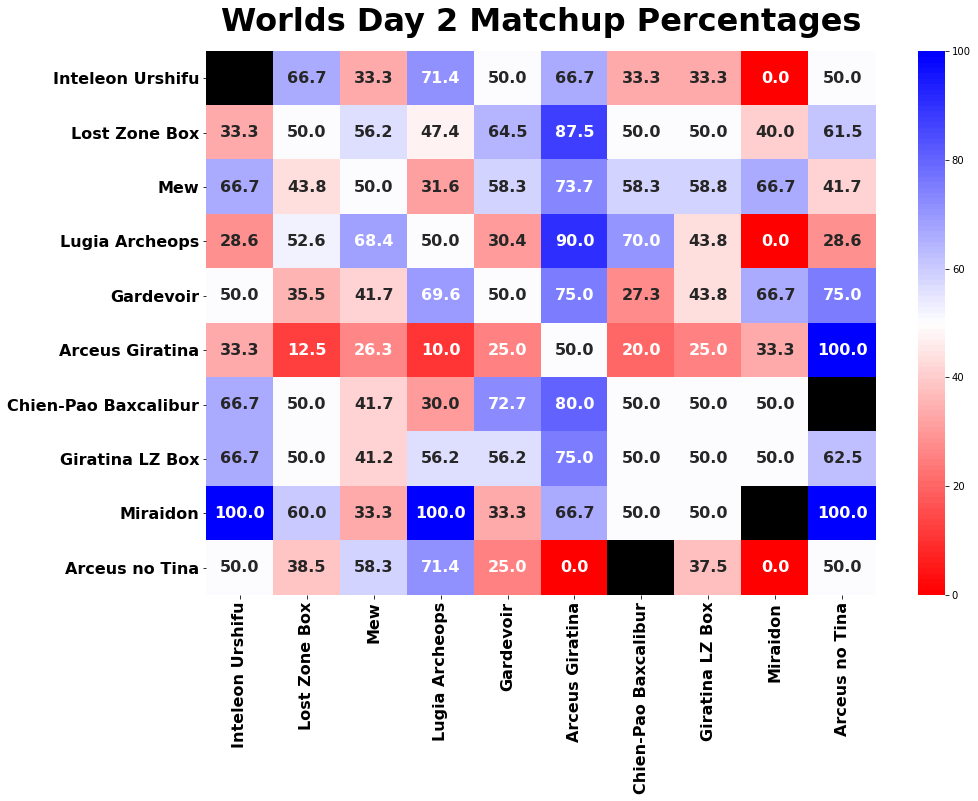

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bins = 100  # Number of bins
cmap_name = 'custom1'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='black')

plt.figure(figsize=(15, 10))
ax = sns.heatmap(percentage_consolidated_df, annot=True, cmap=custom_cmap, fmt=".1f", 
            annot_kws={"weight": "bold", "size": 16})


plt.xticks(fontweight='bold', fontsize= 16)
plt.yticks(fontweight='bold', fontsize= 16)

plt.title('Worlds Day 2 Matchup Percentages', fontweight='bold', fontsize= 32, pad=20)


plt.show()


In [199]:
matchup_df.to_excel("worlds_day2_matchups_records_full.xlsx")
percentage_df.to_excel("worlds_day2_matchups_percent_full.xlsx")
matchup2_df.to_excel("worlds_day2_matchups_records_consolidated.xlsx")
percentage_consolidated_df.to_excel("worlds_day2_matchups_percent_consolidated.xlsx")

In [ ]:
#take into CP for the decks played - "regress out the CP"
    #take leaderboard data and merge with player/deck/matchup table (before i drop player names) to include CP totals
    #can also do day 2 invitees and see how they compare to day 1 players
#change the size of the numbers to express number of games played